In [1]:
import torch
import gc

gc.collect()

torch.cuda.empty_cache()

In [2]:
pip install -qq transformers

     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 67.5 MB/s 
     |████████████████████████████████| 6.6 MB 47.3 MB/s 


In [ ]:
#conda install pytorch torchvision -c pytorch
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.8 kB/s 
     |████████████████████████████████| 8.8 MB 23.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Tweet100.csv to Tweet100.csv


In [23]:
df2 = pd.read_csv('/content/beyond_meat.csv',encoding='latin-1')

In [24]:
df = df2[['content','compound']]

In [25]:
df['Sentiment'] = [1 if x > 0 else 0 for x in df['compound']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
df.rename(columns = {'content':'Tweet'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
df.head()

,Tweet,compound,Sentiment
0,Just posted a photo @ KX burger &amp; beyond h...,0.0000,0
1,@tonyposnanski Dutch Stew. \nBeyond Beef burge...,0.2500,1
2,@TheStanitarium @FeedbackNFuzz I still make Im...,0.2732,1
3,"Well, Merry Christmas to us. @blackstone final...",-0.2500,0
4,@Jeniferium I wish beyond burgers had actual e...,0.4019,1


In [29]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Sentiment"] = label_encoder.fit_transform(df["Sentiment"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Shape of the data

In [30]:
print("Shape of data=>",df.shape)

Shape of data=> (6000, 3)


Describing the data

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tweet      6000 non-null   object 
 1   compound   6000 non-null   float64
 2   Sentiment  6000 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 140.8+ KB


Checking for NULL values in dataset

In [32]:
df.isnull().sum()

Tweet        0
compound     0
Sentiment    0
dtype: int64

No null values

In [33]:
df['Sentiment'].unique()

array([0, 1])

Barchart plotting the negative(0) tweets and positive(1) tweets

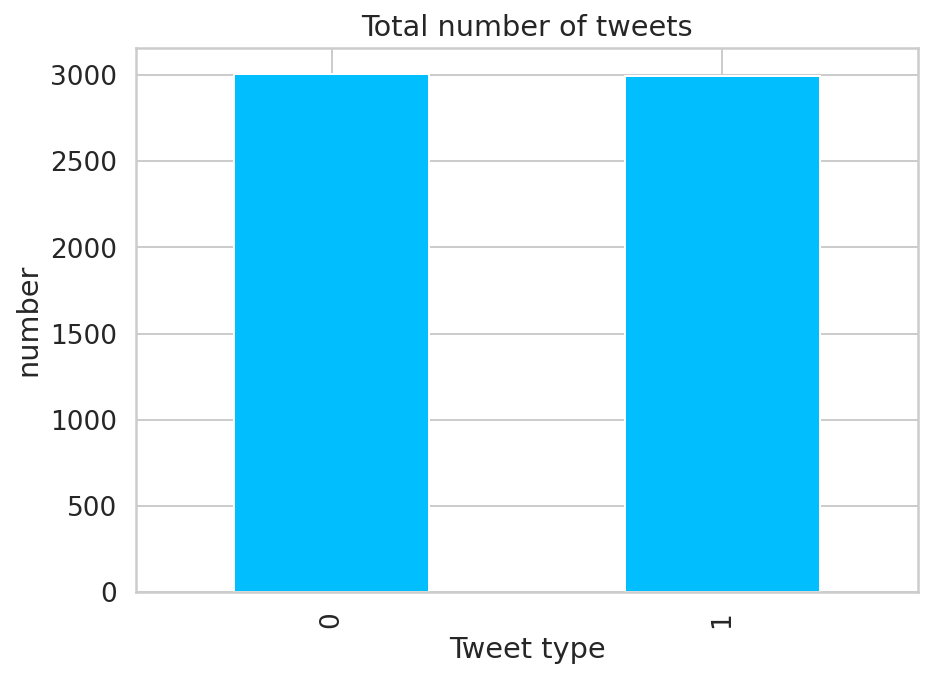

In [34]:
df['Sentiment'].value_counts().plot(kind='bar',figsize=(7,5));
plt.title('Total number of tweets');
plt.xlabel('Tweet type');
plt.ylabel('number');

In [35]:
df.head()

,Tweet,compound,Sentiment
0,Just posted a photo @ KX burger &amp; beyond h...,0.0000,0
1,@tonyposnanski Dutch Stew. \nBeyond Beef burge...,0.2500,1
2,@TheStanitarium @FeedbackNFuzz I still make Im...,0.2732,1
3,"Well, Merry Christmas to us. @blackstone final...",-0.2500,0
4,@Jeniferium I wish beyond burgers had actual e...,0.4019,1


In [36]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

df['Tweet'] = df.Tweet.apply(process_text)
labels = df.Sentiment.values
text = df.Tweet.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Dividing the positive tweets to build the word cloud

In [37]:
df_positive = df[df.Sentiment==1]
df_positive.head()

,Tweet,compound,Sentiment
1,"entity dutch stew. \nbeyond beef burger, sautã...",0.2500,1
2,entity entity i still make impossible tacos an...,0.2732,1
4,entity i wish beyond burgers had actual estrog...,0.4019,1
7,whats the number of beyond burgers you would h...,0.0772,1
10,entity i used to like the regular burgers but ...,0.1901,1


In [38]:
#conda install -c conda-forge wordcloud=1.6.0 
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [151]:
from wordcloud import WordCloud, STOPWORDS
stop_words = ["entity","quot",'beyond',"burger","hashtag","amp","burgers"] + list(STOPWORDS)

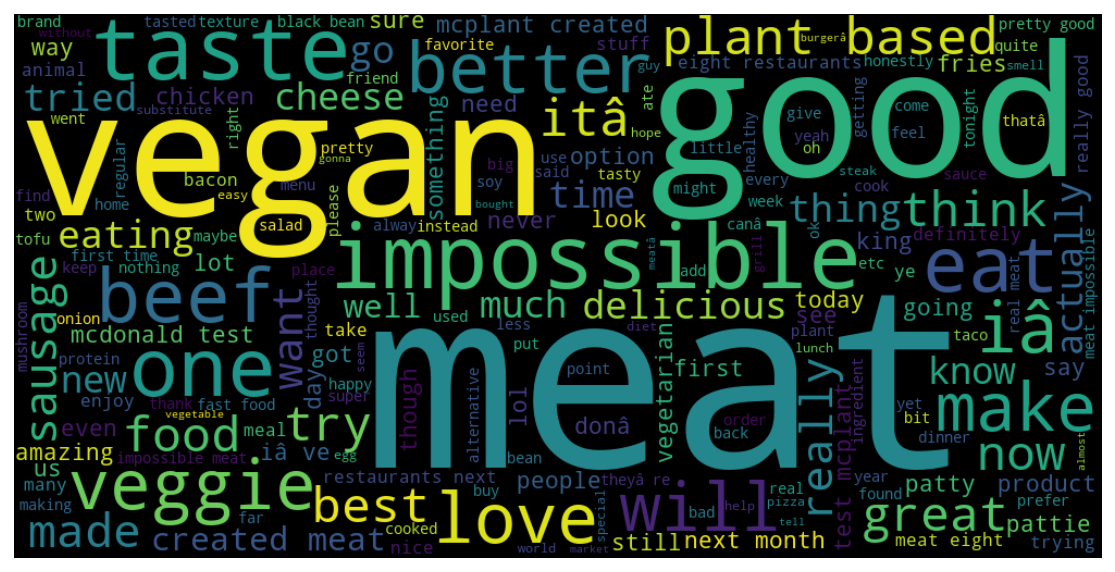

In [152]:
wcp= (' '.join(df_positive['Tweet']))
wordcloud = WordCloud(stopwords = stop_words,width = 1000, height = 500).generate(wcp)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()
display()

Dividing the negative tweets to build the word cloud

In [153]:
df_negative = df[df.Sentiment==0]
df_negative.head()

,Tweet,compound,Sentiment
0,just posted a photo @ kx burger &amp; beyond,0.00,0
3,"well, merry christmas to us. entity finally ar...",-0.25,0
5,entity entity entity how in the world is monst...,0.00,0
6,entity beyond is already there with burgers an...,0.00,0
8,entity entity lmfaoooo why would this change a...,0.00,0


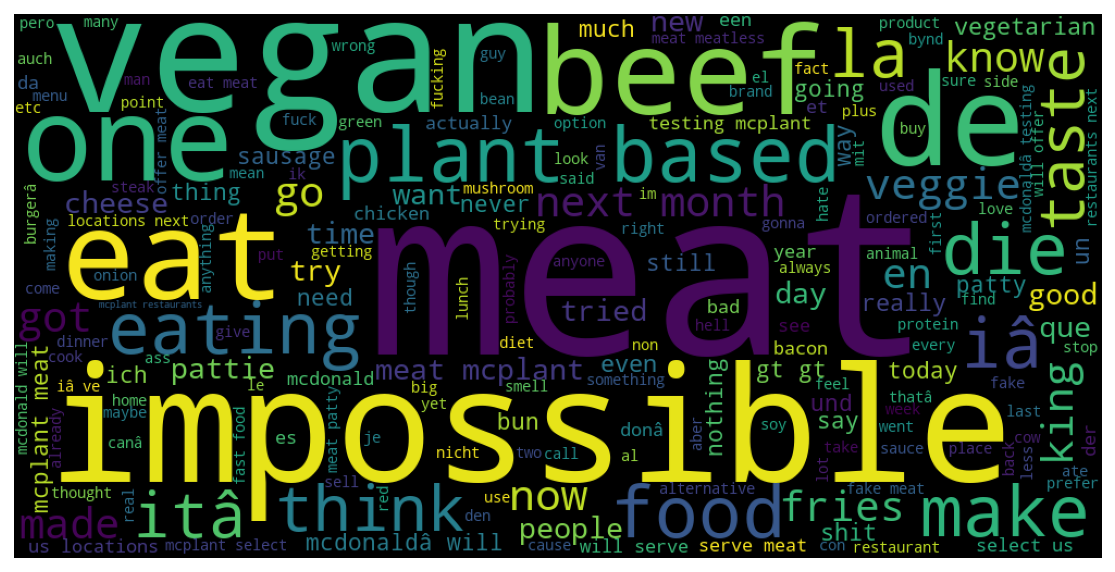

In [154]:
wcn= (' '.join(df_negative['Tweet']))
wordcloud = WordCloud(stopwords = stop_words,width = 1000, height = 500).generate(wcn)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
display()

Naming the classes we are going to use

In [49]:
class_names = ['negative', 'positive']

Selecting bert-base-cased pretrained model

In [50]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [51]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [52]:
df.Tweet[10]

"entity i used to like the regular burgers but then when i gave up red meat i never ate there and then on my trip i tried the beyond meat and now i've had 4 (6 patties bc two of them were doubles)"

Converting the text to numbers 

In [53]:
sample_text = df.Tweet[10]

In [54]:
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: entity i used to like the regular burgers but then when i gave up red meat i never ate there and then on my trip i tried the beyond meat and now i've had 4 (6 patties bc two of them were doubles)
   Tokens: ['entity', 'i', 'used', 'to', 'like', 'the', 'regular', 'b', '##urger', '##s', 'but', 'then', 'when', 'i', 'gave', 'up', 'red', 'meat', 'i', 'never', 'ate', 'there', 'and', 'then', 'on', 'my', 'trip', 'i', 'tried', 'the', 'beyond', 'meat', 'and', 'now', 'i', "'", 've', 'had', '4', '(', '6', 'pat', '##ties', 'b', '##c', 'two', 'of', 'them', 'were', 'doubles', ')']
Token IDs: [9127, 178, 1215, 1106, 1176, 1103, 2366, 171, 23872, 1116, 1133, 1173, 1165, 178, 1522, 1146, 1894, 6092, 178, 1309, 8756, 1175, 1105, 1173, 1113, 1139, 3868, 178, 1793, 1103, 2894, 6092, 1105, 1208, 178, 112, 1396, 1125, 125, 113, 127, 26227, 4338, 171, 1665, 1160, 1104, 1172, 1127, 7952, 114]


In [55]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [56]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [57]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [58]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [59]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=70,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [60]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

70


tensor([  101,  9127,   178,  1215,  1106,  1176,  1103,  2366,   171, 23872,
         1116,  1133,  1173,  1165,   178,  1522,  1146,  1894,  6092,   178,
         1309,  8756,  1175,  1105,  1173,  1113,  1139,  3868,   178,  1793,
         1103,  2894,  6092,  1105,  1208,   178,   112,  1396,  1125,   125,
          113,   127, 26227,  4338,   171,  1665,  1160,  1104,  1172,  1127,
         7952,   114,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [61]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

70


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [62]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'entity',
 'i',
 'used',
 'to',
 'like',
 'the',
 'regular',
 'b',
 '##urger',
 '##s',
 'but',
 'then',
 'when',
 'i',
 'gave',
 'up',
 'red',
 'meat',
 'i',
 'never',
 'ate',
 'there',
 'and',
 'then',
 'on',
 'my',
 'trip',
 'i',
 'tried',
 'the',
 'beyond',
 'meat',
 'and',
 'now',
 'i',
 "'",
 've',
 'had',
 '4',
 '(',
 '6',
 'pat',
 '##ties',
 'b',
 '##c',
 'two',
 'of',
 'them',
 'were',
 'doubles',
 ')',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [63]:
token_lens = []
for txt in df.Tweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

In [64]:
len(token_lens)

6000

In [65]:
token_lens[0:10]

[16, 63, 53, 52, 16, 48, 16, 25, 31, 10]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


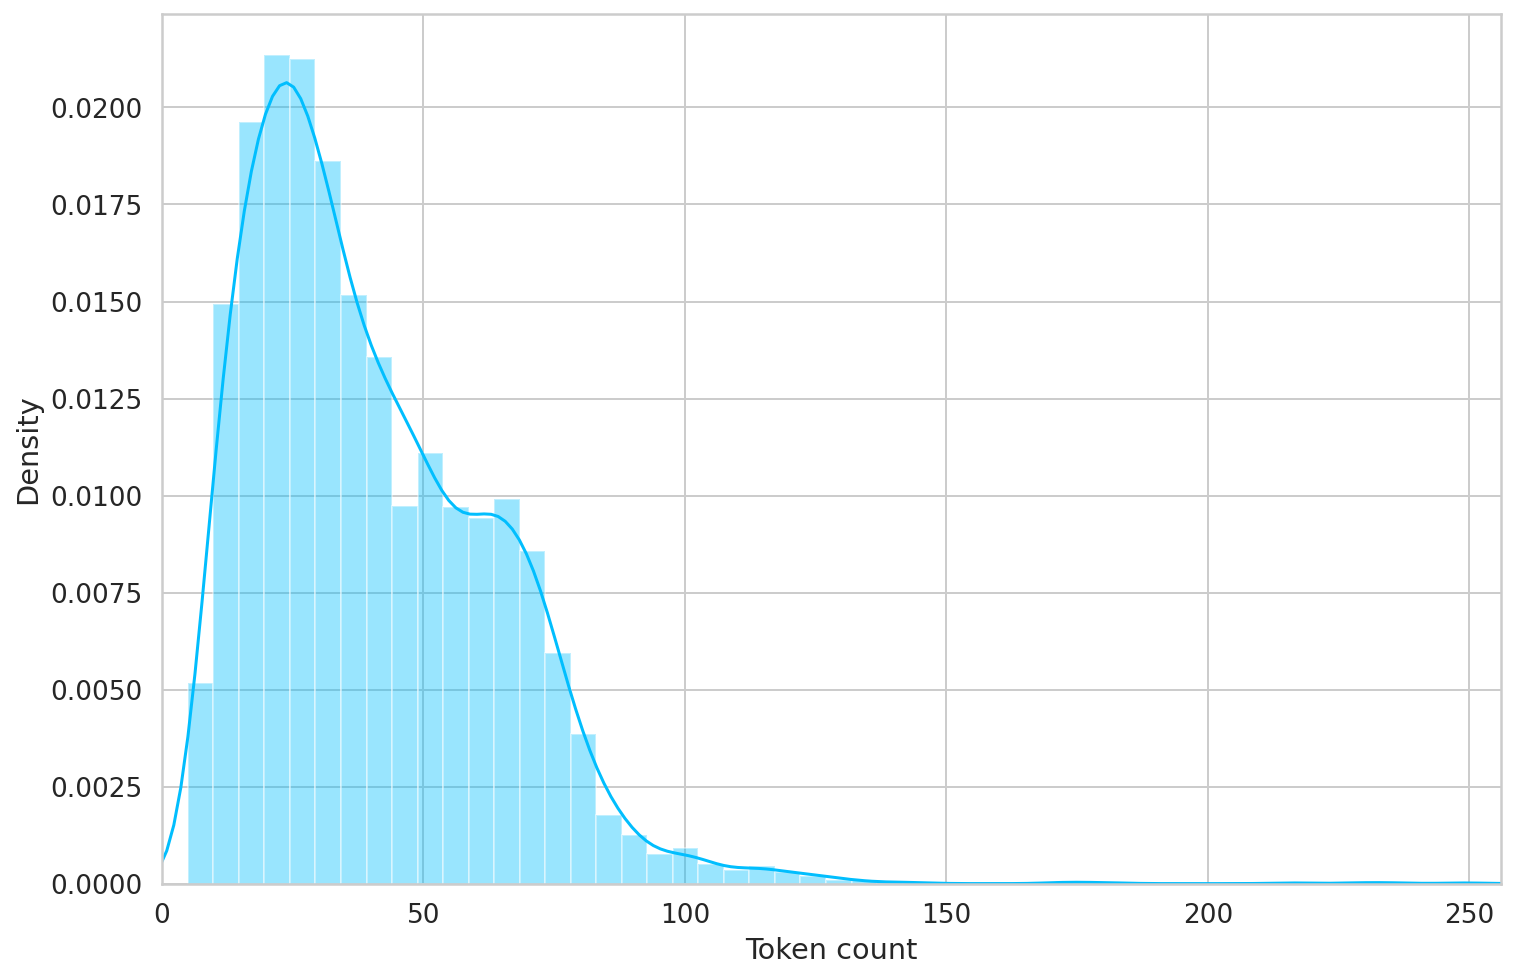

In [66]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.show()
display()

Maximum number of tokens 100

> Indented block




In [67]:
MAX_LEN = 100

Splitting data into Training, Validation and test sets

In [68]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [69]:
df_train.shape, df_val.shape, df_test.shape

((5400, 3), (300, 3), (300, 3))

Dataloader is used to iterate through the data, manage batches, transform the data

In [70]:
class TweetDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]
        #print(target)
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',)  
        #print(encoding)
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [71]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        tweets=df.Tweet.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0 #no.of CPUs used
    )

In [72]:
BATCH_SIZE = 64

In [73]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [74]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [75]:
data = next(iter(train_data_loader))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [76]:
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [77]:
data['input_ids'].shape

torch.Size([64, 100])

In [78]:
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 100])
torch.Size([64])


In [79]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [80]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [81]:
bert_model.config.hidden_size

768

In [82]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [83]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [84]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 100])
torch.Size([64, 100])


In [85]:
import torch.nn.functional as F

In [86]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3380, 0.6620],
        [0.4191, 0.5809],
        [0.5633, 0.4367],
        [0.3548, 0.6452],
        [0.7308, 0.2692],
        [0.3974, 0.6026],
        [0.4735, 0.5265],
        [0.6563, 0.3437],
        [0.6819, 0.3181],
        [0.6662, 0.3338],
        [0.6526, 0.3474],
        [0.6389, 0.3611],
        [0.3564, 0.6436],
        [0.5292, 0.4708],
        [0.6297, 0.3703],
        [0.2886, 0.7114],
        [0.4168, 0.5832],
        [0.4921, 0.5079],
        [0.3862, 0.6138],
        [0.6504, 0.3496],
        [0.5803, 0.4197],
        [0.5579, 0.4421],
        [0.5481, 0.4519],
        [0.3083, 0.6917],
        [0.4181, 0.5819],
        [0.3213, 0.6787],
        [0.4916, 0.5084],
        [0.4923, 0.5077],
        [0.7460, 0.2540],
        [0.4179, 0.5821],
        [0.3381, 0.6619],
        [0.3223, 0.6777],
        [0.5789, 0.4211],
        [0.3909, 0.6091],
        [0.3868, 0.6132],
        [0.5431, 0.4569],
        [0.5395, 0.4605],
        [0.4519, 0.5481],
        [0.4

Using the optimizer to reduce the loss function


In [87]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [88]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [89]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

Training the Data

In [90]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.5427419837783365 accuracy 0.7259259259259259
Val   loss 0.3732188940048218 accuracy 0.8600000000000001

Epoch 2/10
----------
Train loss 0.28737524625133065 accuracy 0.8901851851851852
Val   loss 0.2734719902276993 accuracy 0.9066666666666667

Epoch 3/10
----------
Train loss 0.1512045776581063 accuracy 0.9462962962962963
Val   loss 0.29685868620872496 accuracy 0.9033333333333334

Epoch 4/10
----------
Train loss 0.08629241767613327 accuracy 0.9746296296296296
Val   loss 0.33824814558029176 accuracy 0.92

Epoch 5/10
----------
Train loss 0.049947658693417905 accuracy 0.9855555555555555
Val   loss 0.4192791819572449 accuracy 0.8966666666666667

Epoch 6/10
----------
Train loss 0.027918968324357755 accuracy 0.9931481481481481
Val   loss 0.4548966586589813 accuracy 0.92

Epoch 7/10
----------
Train loss 0.016459902647115728 accuracy 0.9962962962962962
Val   loss 0.48124096989631654 accuracy 0.92

Epoch 8/10
----------
Train loss 0.010719722516232115 accuracy 0.997962962962962

In [144]:
history['train_acc'][0]

tensor(0.7259, device='cuda:0', dtype=torch.float64)

In [148]:
a = torch.tensor(history['train_acc'])
b = torch.tensor(history['val_acc'])

In [149]:
train_acc = a.cpu().detach().numpy()
val_acc = b.cpu().detach().numpy()

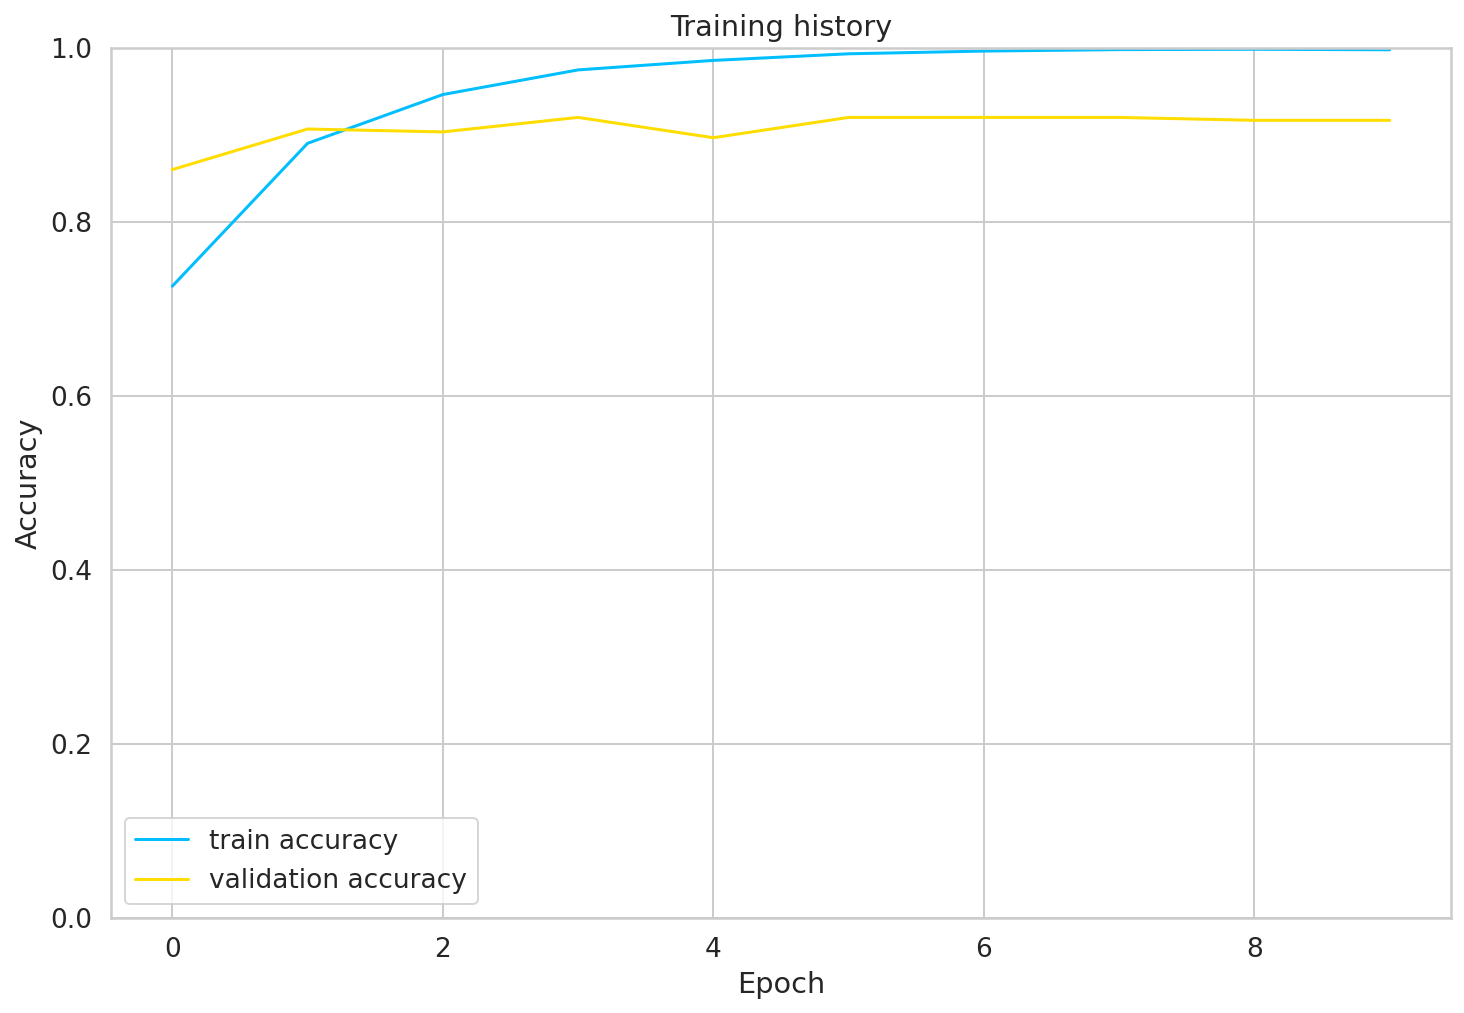

In [150]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Applying the model on the test set

In [95]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.9066666666666667

In [96]:
def get_predictions(model, data_loader):
  model = model.eval()
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      tweet_texts.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [97]:
y_tweets, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Classification report from sklearn metrics 

In [98]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.95      0.91       146
    positive       0.95      0.86      0.90       154

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



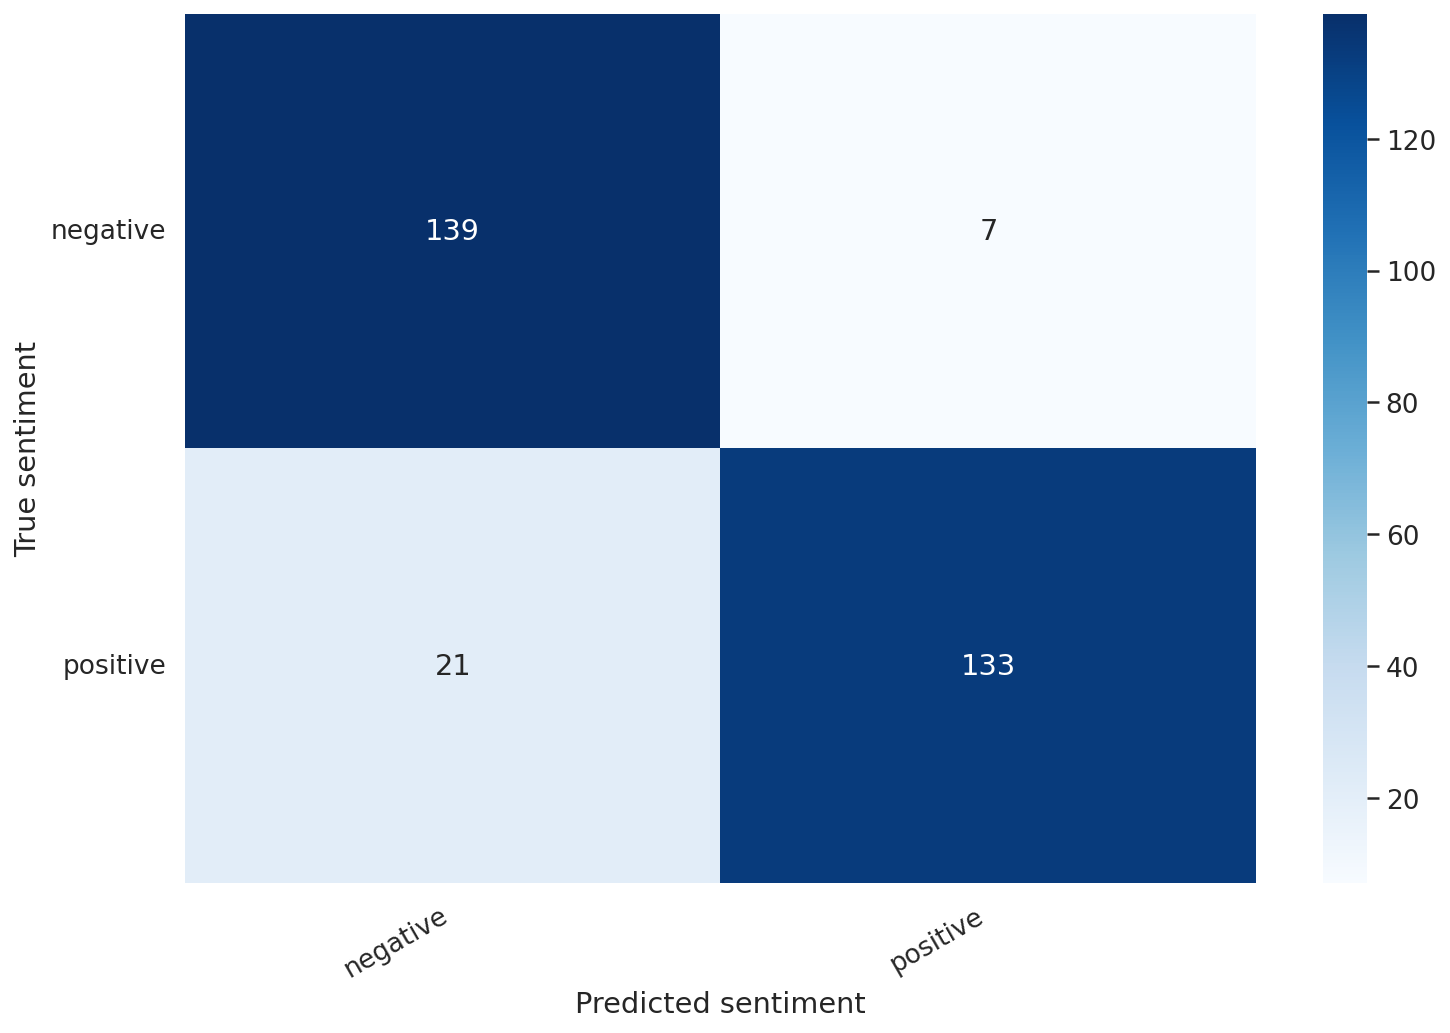

In [99]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [100]:
df_cm

,negative,positive
negative,139,7
positive,21,133


Creating new dataframes with predicted values and original values

In [101]:
pred_df = pd.DataFrame(y_tweets, columns = ['Tweet'])
pred_df_ogn = pd.DataFrame(y_tweets, columns = ['Tweet'])

In [102]:
pred_df['Sentiment'] = y_pred
pred_df_ogn['Sentiment'] = y_test

In [103]:
pred_df.tail()

,Tweet,Sentiment
295,gisteren uiteten met collegaâs. de beyond bu...,0
296,entity entity entity entity there are plenty o...,1
297,entity burger king ????,0
298,itâs 2 am and iâm making a beyond burger,0
299,entity unfortunately the boi has already been ...,0


In [104]:
pred_df_ogn.tail()

,Tweet,Sentiment
295,gisteren uiteten met collegaâs. de beyond bu...,0
296,entity entity entity entity there are plenty o...,1
297,entity burger king ????,0
298,itâs 2 am and iâm making a beyond burger,0
299,entity unfortunately the boi has already been ...,0


In [105]:
pred_df_positive = pred_df[pred_df.Sentiment==1]
pred_df_negative = pred_df[pred_df.Sentiment==0]
pred_df_positive_ogn = pred_df_ogn[pred_df_ogn.Sentiment==1]
pred_df_negative_ogn = pred_df_ogn[pred_df_ogn.Sentiment==0]

In [106]:
print(pred_df_positive.shape)
print(pred_df_negative.shape)

(140, 2)
(160, 2)


In [107]:
print(pred_df_positive_ogn.shape)
print(pred_df_negative_ogn.shape)

(154, 2)
(146, 2)


Positive wordcloud of predicted values

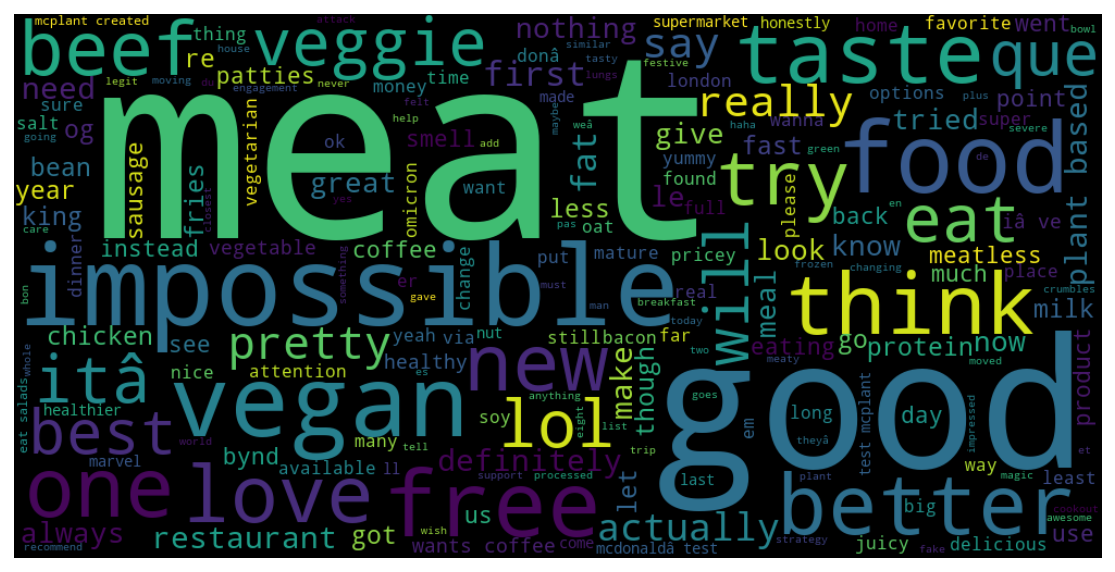

In [155]:
from wordcloud import WordCloud, STOPWORDS
pwcp= (' '.join(pred_df_positive['Tweet']))
wordcloud = WordCloud(stopwords = stop_words, width = 1000, height = 500).generate(pwcp)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()
display()

Positive wordcloud of real values

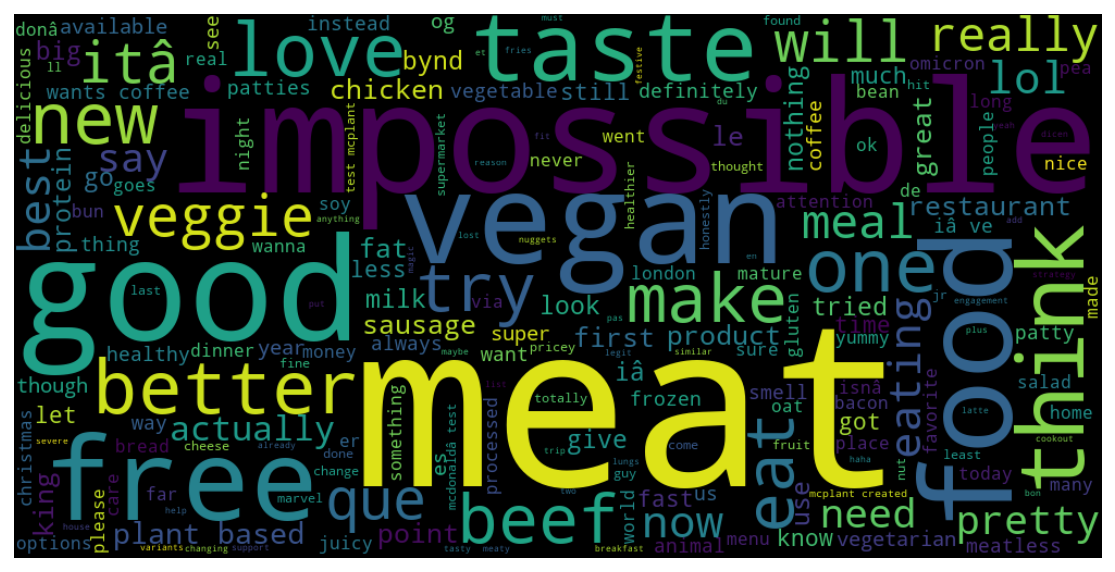

In [156]:
from wordcloud import WordCloud, STOPWORDS
pwcp_o= (' '.join(pred_df_positive_ogn['Tweet']))
wordcloud = WordCloud(stopwords = stop_words,width = 1000, height = 500).generate(pwcp_o)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()
display()

Negative word cloud of predicted values

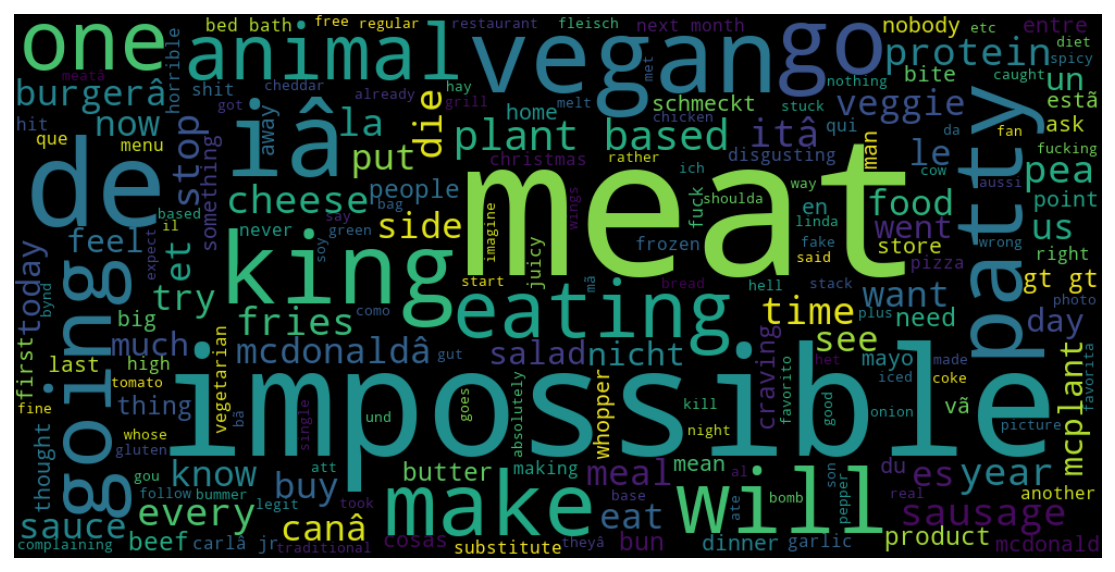

In [157]:
from wordcloud import WordCloud, STOPWORDS
pwcn= (' '.join(pred_df_negative['Tweet']))
wordcloud = WordCloud(stopwords = stop_words,width = 1000, height = 500).generate(pwcn)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()
display()

Negative wordcloud of real values


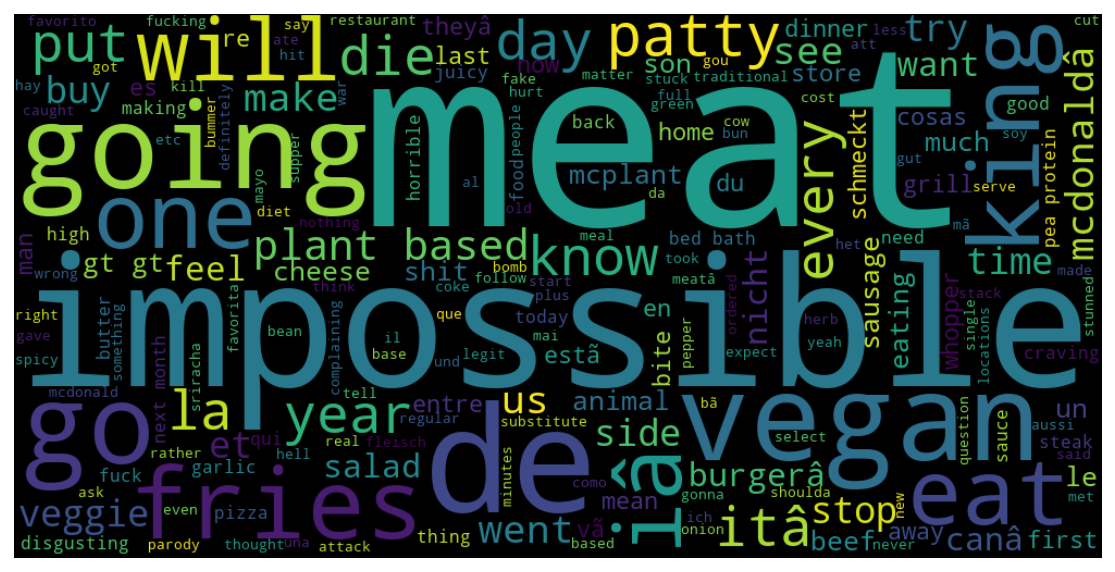

In [158]:
from wordcloud import WordCloud, STOPWORDS
pwcn_o= (' '.join(pred_df_negative_ogn['Tweet']))
wordcloud = WordCloud(stopwords = stop_words,width = 1000, height = 500).generate(pwcn_o)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()
display()

Predicting on the tweet that has never seen before

In [124]:
tweet_new = "This burger is so good. I have trying so many restaaurants and finally I found the right one"
tweet_new1 = "I can't believe this is all we get as a vegan. Tastes like crap and I'm never buying it"
tweet_new2 = "Please stop making this. I don't think I can tolerate this burger anymore"

In [125]:
def get_encode(tweettext):
  encoded_tweet = tokenizer.encode_plus(
    tweettext,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    )
  return encoded_tweet

In [126]:
encoded_tweet = get_encode(tweet_new)
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Tweet: {tweet_new}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet: This burger is so good. I have trying so many restaaurants and finally I found the right one
Sentiment  : positive


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [127]:
encoded_tweet = get_encode(tweet_new1)
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Tweet: {tweet_new1}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet: I can't believe this is all we get as a vegan. Tastes like crap and I'm never buying it
Sentiment  : negative


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [128]:
encoded_tweet = get_encode(tweet_new2)
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Tweet: {tweet_new2}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet: Please stop making this. I don't think I can tolerate this burger anymore
Sentiment  : negative


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
